<a href="https://colab.research.google.com/github/JairoMillapan/Tarea_2_IA/blob/main/2023_2_UOH_COM4402_Tarea_2_JairoMillapan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Jairo Millapán

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [47]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Subir datasets de dígitos (train)

In [48]:
!wget https://github.com/JairoMillapan/Tarea_2_IA/raw/main/1_digits_train.txt

--2023-10-30 04:51:50--  https://github.com/JairoMillapan/Tarea_2_IA/raw/main/1_digits_train.txt
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JairoMillapan/Tarea_2_IA/main/1_digits_train.txt [following]
--2023-10-30 04:51:50--  https://raw.githubusercontent.com/JairoMillapan/Tarea_2_IA/main/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt.2’

1_digits_train.txt. 100%[===================>] 625.59K  --.-KB/s    in 0.04s   

2023-10-30 04:51:51 (16.7 MB/s) - ‘1_digits_train.txt.2’ saved [640604/640604]



In [49]:
!wget https://github.com/JairoMillapan/Tarea_2_IA/raw/main/1_digits_test.txt

--2023-10-30 04:51:51--  https://github.com/JairoMillapan/Tarea_2_IA/raw/main/1_digits_test.txt
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JairoMillapan/Tarea_2_IA/main/1_digits_test.txt [following]
--2023-10-30 04:51:51--  https://raw.githubusercontent.com/JairoMillapan/Tarea_2_IA/main/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187595 (183K) [text/plain]
Saving to: ‘1_digits_test.txt.2’

1_digits_test.txt.2 100%[===================>] 183.20K  --.-KB/s    in 0.02s   

2023-10-30 04:51:52 (7.56 MB/s) - ‘1_digits_test.txt.2’ saved [187595/187595]



## Leer dataset de dígitos

In [50]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [51]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [52]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [53]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [54]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-54-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-54-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-54-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if colu

In [55]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Crear modelo

In [56]:
model = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10)
        )

In [57]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Crear datasets y dataloaders para pytorch (train)

In [58]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [59]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [60]:
batch_size = 128
patience = 10
max_epochs = 1000

#Función para cargar datos y crear dataloaders
def create_dataloader(df, batch_size=128):
    feats = df.iloc[:, :64].to_numpy().astype(np.float32)
    labels = df.iloc[:, 64].astype(int)
    dataset = [{"features": feats[i, :], "labels": labels.iloc[i]} for i in range(len(feats))]
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    return dataloader

#Función para entrenar y evaluar el modelo
def train_and_evaluate(model, dataloader_train, dataloader_val, patience=10, max_epochs=1000): #Como parámetros recibe el modelo de la red neuronal, los dataloaders de entrenamiento y validación
#el parámetro patience para evitar el overfitting y el número de épocas
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Preparamos el modelo para moverlo a gpu
    model = model.to(device) #Movemos el modelo para ejecutarlo en gpu

    criterion = nn.CrossEntropyLoss() #Línea que permite controlar la pérdida
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #Línea que permite optimizar el funcionamiento del código

    best_validation_loss = float('inf') #Registra el mejor valor de pérdida de validación
    epochs_without_improvement = 0 #Cuenta las cantidades de épocas sin mejora

    loss_train = [] #Arreglo para guardar la pérdida del entrenamiento
    loss_val = [] #Arreglo para guardar la pérdida de validación
    epochs = [] #Arreglo que guarda las épocas

    start = time.time() #Comenzamos el contador para saber cuánto demora el entrenamiento

    for epoch in range(max_epochs): #Creamos un ciclo, que se repetirá hasta las 1000 épocas
        loss_train_batches = [] #Arreglo para guardar las pérdidas de entrenamiento
        loss_val_batches = [] #Arreglo para guardar las pérdidas de validación

        model.train() #Con esta línea, nuestro modelo de red neuronal está en modo entrenamiento

        for i, data in enumerate(dataloader_train, 0): #En este recorremos los datos de entrenamiento,
        #se mueven los datos y etiquetas, se calcula la pérdida, se realiza la retropropagación y se actualizan los pesos del modelo.
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train_batches.append(loss.item())

        loss_train.append(np.mean(loss_train_batches)) #Guardamos los valores de pérdida de entrenamiento de cada época

        model.eval() #Colocamos el modelo en modo evaluación

        with torch.no_grad():
            for i, data in enumerate(dataloader_val, 0): #En este bucle recorremos los datos de validación y se calcula la pérdida de validación.
                inputs = data["features"].to(device)
                labels = data["labels"].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss_val_batches.append(loss.item())

        loss_val.append(np.mean(loss_val_batches)) #Guardamos los valores de pérdida de validación de cada época
        epochs.append(epoch) #Guardamos las épocas ejecutadas

        print("Epoch: %d, train loss: %.4f, val loss: %.4f" % (epoch, loss_train[epoch], loss_val[epoch])) #Imprimimos el número de cada época, la pérdida de entrenamiento de esa época y la pérdida de
        #validación de esa época

        #Condicionales creadas con el fin de evitar el overfitting, las condiciones son, si no hay mejora en la pérdida de validación se deja de ejecutar el código
        if loss_val[epoch] < best_validation_loss: #si es menor la pérdida de validación a la mejor pérdida de validación
            best_validation_loss = loss_val[epoch] #se convertirá en la nueva mejor pérdida
            torch.save(model.state_dict(), 'best_model_checkpoint.pth') #guardamos
            epochs_without_improvement = 0 #no hay épocas sin mejora
        else:
            epochs_without_improvement += 1 #sino, agregamos 1

        if epochs_without_improvement >= patience: #cuando las épocas sin mejora superan a 10
            break #termina de ejecutarse el entrenamiento

    end = time.time() #terminamos el tiempo
    print('Finished Training, total time %f seconds' % (end - start)) #imprimimos el tiempo final de ejecución

    return loss_train, loss_val, epochs #retornamos

#Función para visualizar la pérdida
def plot_loss(epochs, loss_train, loss_val): #parámetros a  graficar
    plt.figure(figsize=(8, 5))
    plt.title('Loss train and val') #título del gráfico
    plt.xlabel('Epochs') #título del eje x
    plt.ylabel('Loss') #título del eje y
    plt.plot(epochs, loss_train, 'b', label='Train') #graficamos la curva de pérdida de entrenamiento
    plt.plot(epochs, loss_val, 'r', label='Val') #graficamos la curva de pérdida de validación
    plt.grid() #agregamos cuadrícula
    plt.legend() #agregamos leyenda para cada curva
    plt.show() #mostramos el gráfico

#Función para calcular y mostrar la matriz de confusión y la precisión normalizada
def evaluate_model(model, dataloader):
    model.eval() #ponemos el modelo en modo evaluación
    all_predictions = [] #arreglo para guardar las predicciones
    all_labels = [] #arreglo para guardar las etiquetas

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Preparamos el modelo para moverlo a gpu

    for i, data in enumerate(dataloader, 0): #bucle para calcular las predicciones con sus respectivas etiquetas
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())

    confusion = confusion_matrix(all_labels, all_predictions, normalize='true') #generamos la matriz de confusión
    accuracy = accuracy_score(all_labels, all_predictions) #generamos la precisión

    disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_labels)) #mostramos la matriz
    disp = disp.plot(cmap="Blues", values_format='.2f') #mostramos la matriz

    print("Accuracy: ", accuracy) #imprimimos la precisión

# **Llamaremos a las funciones principales en las siguientes celdas, con los parámetros solicitados en cada punto**

# **(a) 10 neuronas en 1 capa oculta, ReLU, 1000 épocas**

Epoch: 0, train loss: 2.2609, val loss: 2.1573
Epoch: 1, train loss: 2.0675, val loss: 1.9597
Epoch: 2, train loss: 1.8594, val loss: 1.7421
Epoch: 3, train loss: 1.6412, val loss: 1.5359
Epoch: 4, train loss: 1.4251, val loss: 1.3331
Epoch: 5, train loss: 1.2307, val loss: 1.1289
Epoch: 6, train loss: 1.0685, val loss: 0.9910
Epoch: 7, train loss: 0.9390, val loss: 0.8793
Epoch: 8, train loss: 0.8352, val loss: 0.7902
Epoch: 9, train loss: 0.7519, val loss: 0.7278
Epoch: 10, train loss: 0.6866, val loss: 0.6400
Epoch: 11, train loss: 0.6250, val loss: 0.6191
Epoch: 12, train loss: 0.5729, val loss: 0.5751
Epoch: 13, train loss: 0.5257, val loss: 0.5178
Epoch: 14, train loss: 0.4800, val loss: 0.4695
Epoch: 15, train loss: 0.4389, val loss: 0.4270
Epoch: 16, train loss: 0.4020, val loss: 0.3947
Epoch: 17, train loss: 0.3681, val loss: 0.3547
Epoch: 18, train loss: 0.3399, val loss: 0.3315
Epoch: 19, train loss: 0.3152, val loss: 0.3097
Epoch: 20, train loss: 0.2937, val loss: 0.3022
Ep

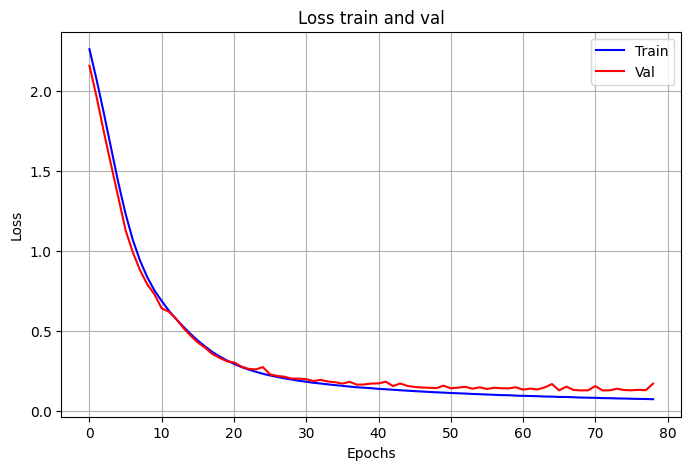

Accuracy:  0.9662835249042145


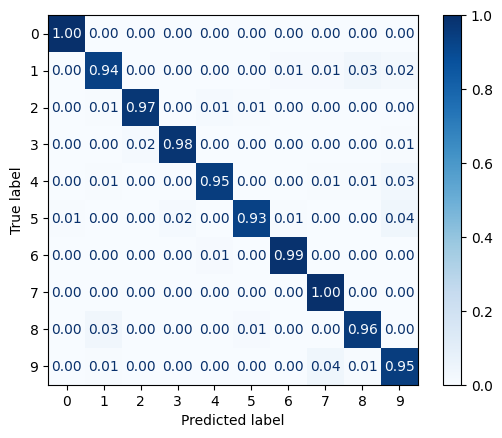

In [61]:
model1 = nn.Sequential(
    nn.Linear(64, 10),
    nn.ReLU(),
    nn.Linear(10, 10)
)
dataloader_train1 = create_dataloader(df_train, batch_size)
dataloader_val1 = create_dataloader(df_val, batch_size)
loss_train1, loss_val1, epochs1 = train_and_evaluate(model1, dataloader_train1, dataloader_val1, patience, max_epochs)
plot_loss(epochs1, loss_train1, loss_val1)
evaluate_model(model1, dataloader_val1)

# **(b) 40 neuronas en 1 capa oculta, ReLU, 1000 épocas**

Epoch: 0, train loss: 2.1311, val loss: 1.9015
Epoch: 1, train loss: 1.6825, val loss: 1.4522
Epoch: 2, train loss: 1.2332, val loss: 1.0267
Epoch: 3, train loss: 0.8525, val loss: 0.7145
Epoch: 4, train loss: 0.6032, val loss: 0.5203
Epoch: 5, train loss: 0.4494, val loss: 0.4002
Epoch: 6, train loss: 0.3547, val loss: 0.3348
Epoch: 7, train loss: 0.2941, val loss: 0.2809
Epoch: 8, train loss: 0.2514, val loss: 0.2409
Epoch: 9, train loss: 0.2200, val loss: 0.2175
Epoch: 10, train loss: 0.1973, val loss: 0.1942
Epoch: 11, train loss: 0.1776, val loss: 0.1756
Epoch: 12, train loss: 0.1624, val loss: 0.1661
Epoch: 13, train loss: 0.1493, val loss: 0.1541
Epoch: 14, train loss: 0.1388, val loss: 0.1501
Epoch: 15, train loss: 0.1286, val loss: 0.1675
Epoch: 16, train loss: 0.1202, val loss: 0.1389
Epoch: 17, train loss: 0.1129, val loss: 0.1450
Epoch: 18, train loss: 0.1057, val loss: 0.1287
Epoch: 19, train loss: 0.0995, val loss: 0.1258
Epoch: 20, train loss: 0.0942, val loss: 0.1237
Ep

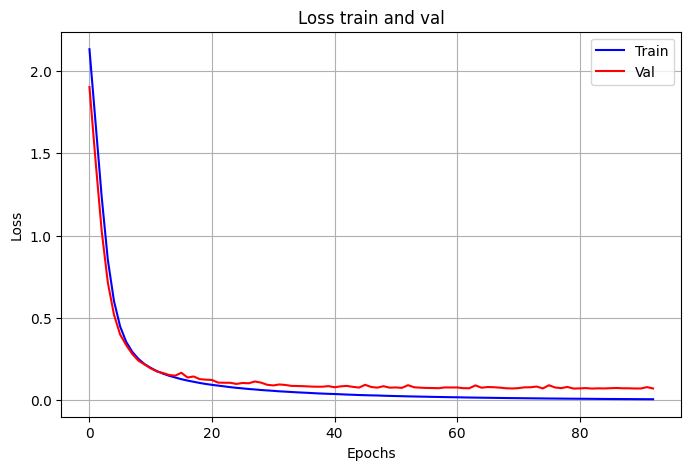

Accuracy:  0.9770114942528736


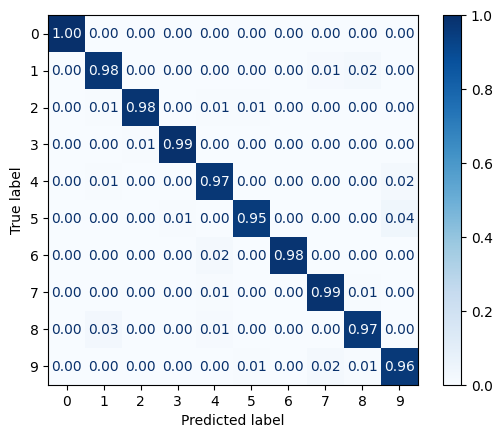

In [62]:
model2 = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 10)
)
dataloader_train2 = create_dataloader(df_train, batch_size)
dataloader_val2 = create_dataloader(df_val, batch_size)
loss_train2, loss_val2, epochs2 = train_and_evaluate(model2, dataloader_train2, dataloader_val2, patience, max_epochs)
plot_loss(epochs2, loss_train2, loss_val2)
evaluate_model(model2, dataloader_val2)

# **(c) 10 neuronas en 1 capa oculta, Tanh, 1000 épocas**

Epoch: 0, train loss: 2.2229, val loss: 2.0802
Epoch: 1, train loss: 1.9691, val loss: 1.8497
Epoch: 2, train loss: 1.7650, val loss: 1.6587
Epoch: 3, train loss: 1.5951, val loss: 1.5087
Epoch: 4, train loss: 1.4482, val loss: 1.3597
Epoch: 5, train loss: 1.3183, val loss: 1.2618
Epoch: 6, train loss: 1.2051, val loss: 1.1454
Epoch: 7, train loss: 1.1040, val loss: 1.0442
Epoch: 8, train loss: 1.0148, val loss: 0.9602
Epoch: 9, train loss: 0.9322, val loss: 0.9018
Epoch: 10, train loss: 0.8571, val loss: 0.8163
Epoch: 11, train loss: 0.7888, val loss: 0.7508
Epoch: 12, train loss: 0.7259, val loss: 0.6922
Epoch: 13, train loss: 0.6689, val loss: 0.6369
Epoch: 14, train loss: 0.6191, val loss: 0.6008
Epoch: 15, train loss: 0.5741, val loss: 0.5490
Epoch: 16, train loss: 0.5353, val loss: 0.5248
Epoch: 17, train loss: 0.4991, val loss: 0.4880
Epoch: 18, train loss: 0.4687, val loss: 0.4821
Epoch: 19, train loss: 0.4403, val loss: 0.4245
Epoch: 20, train loss: 0.4162, val loss: 0.4002
Ep

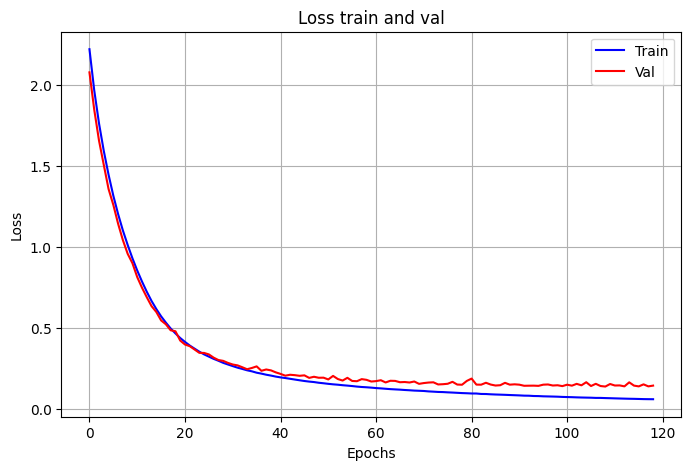

Accuracy:  0.9578544061302682


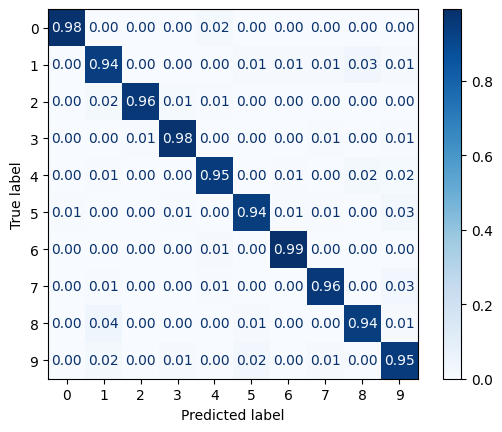

In [63]:
model3 = nn.Sequential(
    nn.Linear(64, 10),
    nn.Tanh(),
    nn.Linear(10, 10)
)
dataloader_train3 = create_dataloader(df_train, batch_size)
dataloader_val3 = create_dataloader(df_val, batch_size)
loss_train3, loss_val3, epochs3 = train_and_evaluate(model3, dataloader_train3, dataloader_val3, patience, max_epochs)
plot_loss(epochs3, loss_train3, loss_val3)
evaluate_model(model3, dataloader_val3)

# **(d) 40 neuronas usando Tanh, 1000 épocas**

Epoch: 0, train loss: 2.0998, val loss: 1.7832
Epoch: 1, train loss: 1.5493, val loss: 1.3098
Epoch: 2, train loss: 1.1479, val loss: 0.9694
Epoch: 3, train loss: 0.8669, val loss: 0.7494
Epoch: 4, train loss: 0.6689, val loss: 0.5886
Epoch: 5, train loss: 0.5337, val loss: 0.4699
Epoch: 6, train loss: 0.4401, val loss: 0.3828
Epoch: 7, train loss: 0.3720, val loss: 0.3455
Epoch: 8, train loss: 0.3226, val loss: 0.2947
Epoch: 9, train loss: 0.2841, val loss: 0.2662
Epoch: 10, train loss: 0.2549, val loss: 0.2366
Epoch: 11, train loss: 0.2301, val loss: 0.2253
Epoch: 12, train loss: 0.2121, val loss: 0.2037
Epoch: 13, train loss: 0.1949, val loss: 0.1920
Epoch: 14, train loss: 0.1807, val loss: 0.1822
Epoch: 15, train loss: 0.1677, val loss: 0.1705
Epoch: 16, train loss: 0.1573, val loss: 0.1671
Epoch: 17, train loss: 0.1476, val loss: 0.1596
Epoch: 18, train loss: 0.1400, val loss: 0.1555
Epoch: 19, train loss: 0.1322, val loss: 0.1580
Epoch: 20, train loss: 0.1251, val loss: 0.1378
Ep

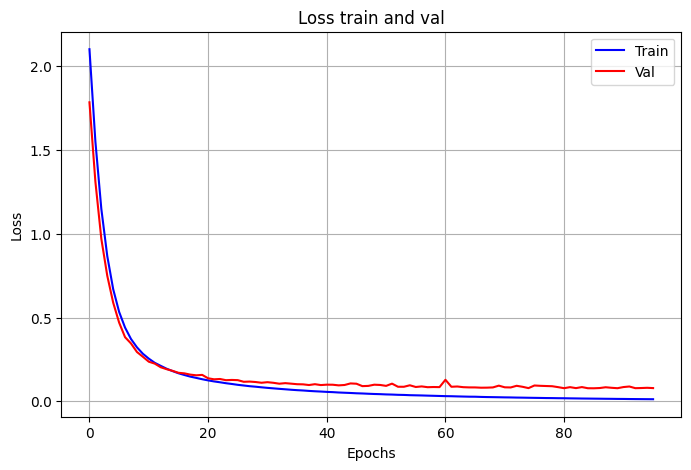

Accuracy:  0.9770114942528736


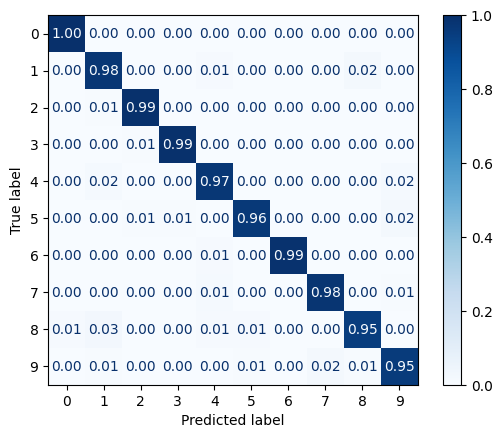

In [64]:
model4 = nn.Sequential(
    nn.Linear(64, 40),
    nn.Tanh(),
    nn.Linear(40, 10)
)
dataloader_train4 = create_dataloader(df_train, batch_size)
dataloader_val4 = create_dataloader(df_val, batch_size)
loss_train4, loss_val4, epochs4 = train_and_evaluate(model4, dataloader_train4, dataloader_val4, patience, max_epochs)
plot_loss(epochs4, loss_train4, loss_val4)
evaluate_model(model4, dataloader_val4)

# **(e) 2 capas ocultas con 10 neuronas, ReLU, 1000 épocas**

Epoch: 0, train loss: 2.3085, val loss: 2.2848
Epoch: 1, train loss: 2.2469, val loss: 2.2186
Epoch: 2, train loss: 2.1548, val loss: 2.0923
Epoch: 3, train loss: 1.9951, val loss: 1.8888
Epoch: 4, train loss: 1.7773, val loss: 1.6511
Epoch: 5, train loss: 1.5432, val loss: 1.4281
Epoch: 6, train loss: 1.3252, val loss: 1.2105
Epoch: 7, train loss: 1.1141, val loss: 0.9982
Epoch: 8, train loss: 0.9165, val loss: 0.7991
Epoch: 9, train loss: 0.7581, val loss: 0.6656
Epoch: 10, train loss: 0.6399, val loss: 0.5967
Epoch: 11, train loss: 0.5513, val loss: 0.5133
Epoch: 12, train loss: 0.4850, val loss: 0.4545
Epoch: 13, train loss: 0.4315, val loss: 0.4075
Epoch: 14, train loss: 0.3894, val loss: 0.3906
Epoch: 15, train loss: 0.3545, val loss: 0.3462
Epoch: 16, train loss: 0.3238, val loss: 0.3109
Epoch: 17, train loss: 0.2987, val loss: 0.2885
Epoch: 18, train loss: 0.2791, val loss: 0.2829
Epoch: 19, train loss: 0.2605, val loss: 0.2746
Epoch: 20, train loss: 0.2451, val loss: 0.2563
Ep

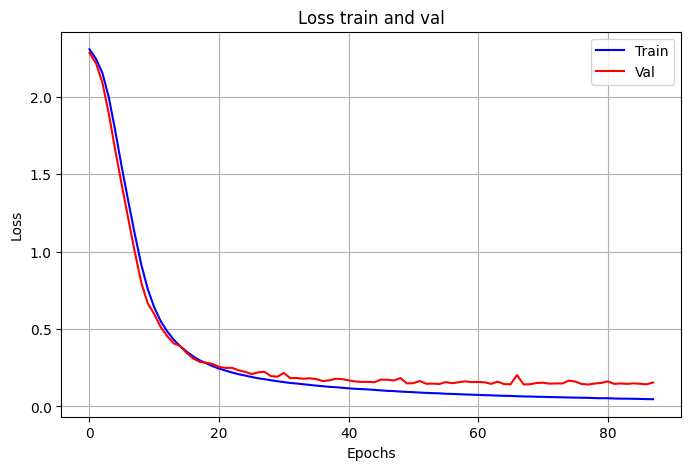

Accuracy:  0.9555555555555556


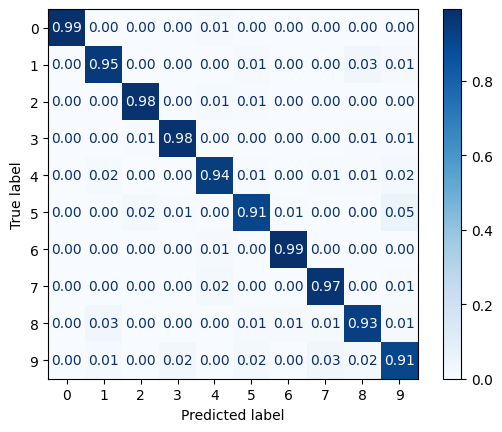

In [65]:
model5 = nn.Sequential(
    nn.Linear(64, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10)
)
dataloader_train5 = create_dataloader(df_train, batch_size)
dataloader_val5 = create_dataloader(df_val, batch_size)
loss_train5, loss_val5, epochs5 = train_and_evaluate(model5, dataloader_train5, dataloader_val5, patience, max_epochs)
plot_loss(epochs5, loss_train5, loss_val5)
evaluate_model(model5, dataloader_val5)

# **(e) 2 capas de 40 neuronas, ReLU, 1000 épocas**

Epoch: 0, train loss: 2.1821, val loss: 2.0164
Epoch: 1, train loss: 1.7753, val loss: 1.4346
Epoch: 2, train loss: 1.1622, val loss: 0.8405
Epoch: 3, train loss: 0.6448, val loss: 0.4507
Epoch: 4, train loss: 0.3675, val loss: 0.2726
Epoch: 5, train loss: 0.2481, val loss: 0.2107
Epoch: 6, train loss: 0.1934, val loss: 0.1725
Epoch: 7, train loss: 0.1600, val loss: 0.1789
Epoch: 8, train loss: 0.1370, val loss: 0.1365
Epoch: 9, train loss: 0.1196, val loss: 0.1391
Epoch: 10, train loss: 0.1042, val loss: 0.1206
Epoch: 11, train loss: 0.0929, val loss: 0.1310
Epoch: 12, train loss: 0.0835, val loss: 0.1070
Epoch: 13, train loss: 0.0754, val loss: 0.1060
Epoch: 14, train loss: 0.0674, val loss: 0.1058
Epoch: 15, train loss: 0.0614, val loss: 0.0958
Epoch: 16, train loss: 0.0557, val loss: 0.1019
Epoch: 17, train loss: 0.0512, val loss: 0.0912
Epoch: 18, train loss: 0.0468, val loss: 0.0998
Epoch: 19, train loss: 0.0435, val loss: 0.0975
Epoch: 20, train loss: 0.0401, val loss: 0.0868
Ep

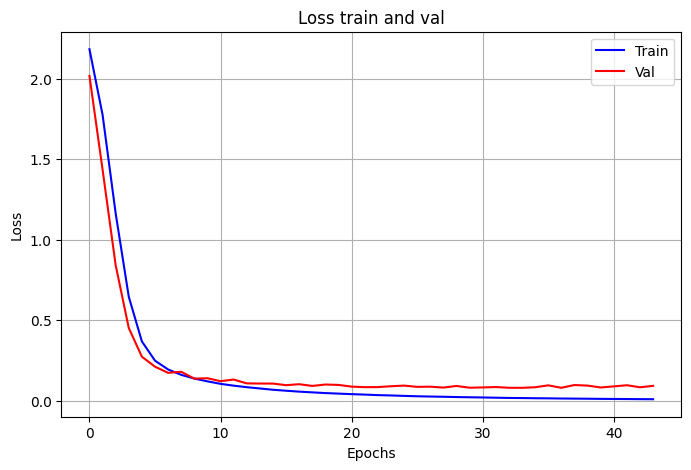

Accuracy:  0.9754789272030652


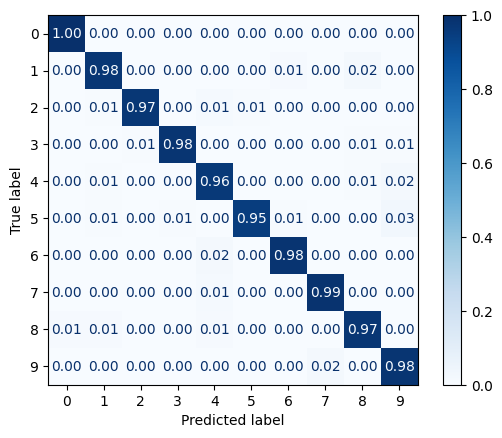

In [66]:
model6 = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Linear(40, 10)
)
dataloader_train6 = create_dataloader(df_train, batch_size)
dataloader_val6 = create_dataloader(df_val, batch_size)
loss_train6, loss_val6, epochs6 = train_and_evaluate(model6, dataloader_train6, dataloader_val6, patience, max_epochs)
plot_loss(epochs6, loss_train6, loss_val6)
evaluate_model(model6, dataloader_val6)

Parte 3) Usando la mejor red en validación, se calcula la matriz de confusión normalizada y el accuracy normalizado, para el conjunto de Prueba

In [67]:
batch_size = 128
patience = 10
max_epochs = 1000

#Función para cargar datos y crear dataloaders
def create_dataloader(df, batch_size=128):
    feats = df.iloc[:, :64].to_numpy().astype(np.float32)
    labels = df.iloc[:, 64].astype(int)
    dataset = [{"features": feats[i, :], "labels": labels.iloc[i]} for i in range(len(feats))]
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    return dataloader

#Función para entrenar y evaluar el modelo
def train_and_evaluate(model, dataloader_train, dataloader_test, patience=10, max_epochs=1000): #Como parámetros recibe el modelo de la red neuronal, los dataloaders de entrenamiento y ahora prueba
#el parámetro patience para evitar el overfitting y el número de épocas
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Preparamos el modelo para moverlo a gpu
    model = model.to(device) #Movemos el modelo para ejecutarlo en gpu

    criterion = nn.CrossEntropyLoss() #Línea que permite controlar la pérdida
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #Línea que permite optimizar el funcionamiento del código

    best_validation_loss = float('inf') #Registra el mejor valor de pérdida de validación
    epochs_without_improvement = 0 #Cuenta las cantidades de épocas sin mejora

    loss_train = [] #Arreglo para guardar la pérdida del entrenamiento
    loss_test = [] #Arreglo para guardar la pérdida de prueba
    epochs = [] #Arreglo que guarda las épocas

    start = time.time() #Comenzamos el contador para saber cuánto demora el entrenamiento

    for epoch in range(max_epochs): #Creamos un ciclo, que se repetirá hasta las 1000 épocas
        loss_train_batches = [] #Arreglo para guardar las pérdidas de entrenamiento
        loss_test_batches = [] #Arreglo para guardar las pérdidas de prueba

        model.train() #Con esta línea, nuestro modelo de red neuronal está en modo entrenamiento

        for i, data in enumerate(dataloader_train, 0): #En este recorremos los datos de entrenamiento,
        #se mueven los datos y etiquetas, se calcula la pérdida, se realiza la retropropagación y se actualizan los pesos del modelo.
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train_batches.append(loss.item())

        loss_train.append(np.mean(loss_train_batches)) #Guardamos los valores de pérdida de entrenamiento de cada época

        model.eval() #Colocamos el modelo en modo evaluación

        with torch.no_grad():
            for i, data in enumerate(dataloader_test, 0): #En este bucle recorremos los datos de validación y se calcula la pérdida de prueba.
                inputs = data["features"].to(device)
                labels = data["labels"].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss_test_batches.append(loss.item())

        loss_test.append(np.mean(loss_test_batches)) #Guardamos los valores de pérdida de prueba de cada época
        epochs.append(epoch) #Guardamos las épocas ejecutadas

        print("Epoch: %d, train loss: %.4f, test loss: %.4f" % (epoch, loss_train[epoch], loss_test[epoch])) #Imprimimos el número de cada época, la pérdida de entrenamiento de esa época y la pérdida de
        #prueba de esa época

        #Condicionales creadas con el fin de evitar el overfitting, las condiciones son, si no hay mejora en la pérdida de prueba se deja de ejecutar el código
        if loss_test[epoch] < best_validation_loss: #si es menor la pérdida de prueba a la mejor pérdida de prueba
            best_validation_loss = loss_test[epoch] #se convertirá en la nueva mejor pérdida
            torch.save(model.state_dict(), 'best_model_checkpoint.pth') #guardamos
            epochs_without_improvement = 0 #no hay épocas sin mejora
        else:
            epochs_without_improvement += 1 #sino, agregamos 1

        if epochs_without_improvement >= patience: #cuando las épocas sin mejora superan a 10
            break #termina de ejecutarse el entrenamiento

    end = time.time() #terminamos el tiempo
    print('Finished Training, total time %f seconds' % (end - start)) #imprimimos el tiempo final de ejecución

    return loss_train, loss_test, epochs #retornamos

#Función para visualizar la pérdida
def plot_loss(epochs, loss_train, loss_test): #parámetros a  graficar
    plt.figure(figsize=(8, 5))
    plt.title('Loss train and test') #título del gráfico
    plt.xlabel('Epochs') #título del eje x
    plt.ylabel('Loss') #título del eje y
    plt.plot(epochs, loss_train, 'b', label='Train') #graficamos la curva de pérdida de entrenamiento
    plt.plot(epochs, loss_test, 'r', label='Test') #graficamos la curva de pérdida de prueba
    plt.grid() #agregamos cuadrícula
    plt.legend() #agregamos leyenda para cada curva
    plt.show() #mostramos el gráfico

#Función para calcular y mostrar la matriz de confusión y la precisión normalizada
def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Preparamos el modelo para moverlo a gpu

    for i, data in enumerate(dataloader, 0): #bucle para calcular las predicciones con sus respectivas etiquetas
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())

    confusion = confusion_matrix(all_labels, all_predictions, normalize='true')
    accuracy = accuracy_score(all_labels, all_predictions)

    disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_labels))
    disp = disp.plot(cmap="Blues", values_format='.2f')

    print("Accuracy: ", accuracy)

Epoch: 0, train loss: 2.1282, test loss: 1.9268
Epoch: 1, train loss: 1.7205, test loss: 1.5151
Epoch: 2, train loss: 1.2904, test loss: 1.0954
Epoch: 3, train loss: 0.9016, test loss: 0.7617
Epoch: 4, train loss: 0.6240, test loss: 0.5473
Epoch: 5, train loss: 0.4533, test loss: 0.4196
Epoch: 6, train loss: 0.3516, test loss: 0.3424
Epoch: 7, train loss: 0.2892, test loss: 0.2933
Epoch: 8, train loss: 0.2478, test loss: 0.2597
Epoch: 9, train loss: 0.2177, test loss: 0.2342
Epoch: 10, train loss: 0.1950, test loss: 0.2142
Epoch: 11, train loss: 0.1770, test loss: 0.1985
Epoch: 12, train loss: 0.1620, test loss: 0.1862
Epoch: 13, train loss: 0.1496, test loss: 0.1749
Epoch: 14, train loss: 0.1387, test loss: 0.1659
Epoch: 15, train loss: 0.1299, test loss: 0.1578
Epoch: 16, train loss: 0.1213, test loss: 0.1516
Epoch: 17, train loss: 0.1140, test loss: 0.1442
Epoch: 18, train loss: 0.1069, test loss: 0.1396
Epoch: 19, train loss: 0.1014, test loss: 0.1344
Epoch: 20, train loss: 0.0953,

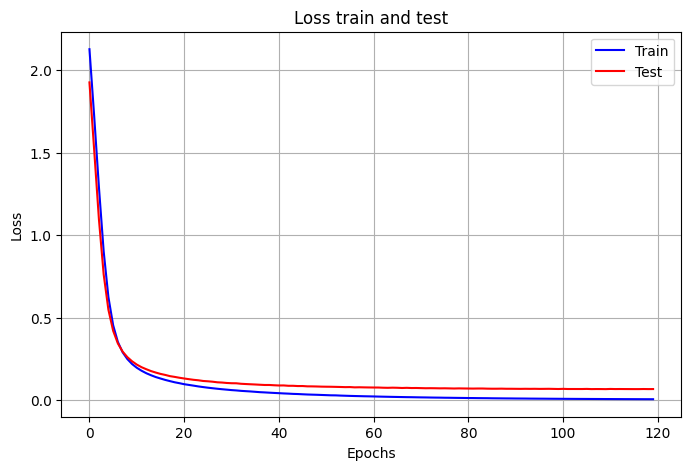

Accuracy:  0.9819182389937107


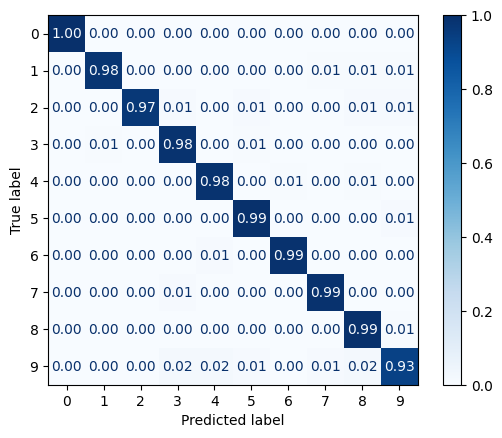

In [68]:
#Modelo 7 correspondiente al modelo 2 del punto (b)
model7 = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 10)
)
dataloader_train7 = create_dataloader(df_train, batch_size)
dataloader_test7 = create_dataloader(df_test, batch_size)
loss_train7, loss_test7, epochs7 = train_and_evaluate(model7, dataloader_train7, dataloader_test7, patience, max_epochs)
plot_loss(epochs7, loss_train7, loss_test7)
evaluate_model(model7, dataloader_test7)